## CSC4160: Cloud Computing Final Project

Modern large-scale cloud providers such as Google Cloud, AWS, and Microsoft Azure execute millions of containerized workloads daily on shared clusters. Each submitted job requires users to specify its CPU and memory requirements before execution. However, these user-provided resource requests are often inaccurate and highly conservative. Users tend to over-request resources to be safe, resulting in underutilization and inflated costs. At the same time, aggressive under-requesting of resources would risk out-of-memory (OOM) failures, job evictions, and service-level agreement (SLA) violations.

### Environment Setup & Library Import
Importing necessary libraries for data manipulation (Pandas), numerical operations (NumPy), and machine learning (Scikit-Learn, LightGBM).

In [25]:
# Data Analysis & Visualization
import json
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Machine Learning - Data Preparation
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Machine Learning - Models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
import lightgbm as lgb

# Machine Learning - Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# Configuration
warnings.filterwarnings("ignore")

### Data Ingestion
The Google Cluster Data is distributed across multiple CSV files. Here, we iterate through the file directory, reading the raw trace logs. To optimize memory usage during the initial load, we concatenate these segments into a single Parquet file, which allows for faster I/O operations in subsequent steps.

In [26]:
# Define the directory path (This looks correct based on your previous attempts)
directory_path = '/Users/chuaqindi/Desktop/google_csv' 

# 1. Update the list of file names to REMOVE the explicit '.csv' extension.
# They should match the names shown in your Finder window.
file_names = [
    'bq-results-20251203-024112-000000000000', # <-- No .csv
    'bq-results-20251203-024112-000000000001', # <-- No .csv
    'bq-results-20251203-024112-000000000002',
    'bq-results-20251203-024112-000000000003',
    'bq-results-20251203-024112-000000000004',
    'bq-results-20251203-024112-000000000005',
    'bq-results-20251203-024112-000000000006',
    'bq-results-20251203-024112-000000000007',
    'bq-results-20251203-024112-000000000008',
    'bq-results-20251203-024112-000000000009',
]

# 2. Use a list comprehension to read all files
df_list = []
print("Starting file import...")

# Read the first file (0000) with the header
file_path_0 = f"{directory_path}/{file_names[0]}"
print(f"Reading {file_names[0]}...")

# The pandas read_csv function is smart enough to handle files that are CSV format
# even if they don't have the .csv extension.
df_0 = pd.read_csv(file_path_0, low_memory=False) 
df_list.append(df_0)


# Read the remaining 9 files without the header
for i in range(1, len(file_names)):
    file_path_i = f"{directory_path}/{file_names[i]}"
    print(f"Reading {file_names[i]}...")

    # Read the file, skipping the header and assigning column names from the first DataFrame
    df_i = pd.read_csv(
        file_path_i, 
        header=None, 
        skiprows=1, 
        low_memory=False, 
        names=df_0.columns # Apply the column names from the first file
    )
    df_list.append(df_i)


# 3. Concatenate all 10 DataFrames
print("\nConcatenating DataFrames...")
combined_df = pd.concat(df_list, ignore_index=True)
print(f"Combined DataFrame has {len(combined_df):,} rows.")

# 4. Save the result
output_filename = 'manually_combined_bq_results.parquet' # Use Parquet for efficiency
combined_df.to_parquet(output_filename, index=False)
print(f"Data successfully saved to {output_filename}.")

Starting file import...
Reading bq-results-20251203-024112-000000000000...
Reading bq-results-20251203-024112-000000000001...
Reading bq-results-20251203-024112-000000000002...
Reading bq-results-20251203-024112-000000000003...
Reading bq-results-20251203-024112-000000000004...
Reading bq-results-20251203-024112-000000000005...
Reading bq-results-20251203-024112-000000000006...
Reading bq-results-20251203-024112-000000000007...
Reading bq-results-20251203-024112-000000000008...
Reading bq-results-20251203-024112-000000000009...

Concatenating DataFrames...
Combined DataFrame has 500,000 rows.
Data successfully saved to manually_combined_bq_results.parquet.


In [27]:
import pandas as pd
df= pd.read_parquet('manually_combined_bq_results.parquet')

In [28]:
pd.set_option("display.max_columns", None)
df.head()   # Display the first few rows of the dataframe

,collection_id,instance_index,machine_id,start_time,end_time,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,max_memory,avg_cpus,avg_memory,max_cpus,instance_events_json,collection_events_json
0,381147481928,1057,4458933235,713400000000,713700000000,0.001719,0.000073,0.743002,0.001359,1.000000,0.001562,0.001438,0.001562,0.004265,"[{""time"":673923662913,""type"":3,""collection_id""...","[{""time"":673910104716,""type"":2,""collection_id""..."
1,290190294224,259,87976653382,531300000000,531600000000,0.002823,0.000169,3.221052,0.025312,0.996667,0.002052,0.000762,0.002048,0.006958,"[{""time"":0,""type"":3,""collection_id"":2901902942...","[{""time"":0,""type"":2,""collection_id"":2901902942..."
2,380695145143,65,4459248955,575371000000,575400000000,0.001783,0.000073,NaN,NaN,1.000000,0.000932,0.001574,0.000273,0.008041,"[{""time"":575350539815,""type"":3,""collection_id""...","[{""time"":575339696708,""type"":2,""collection_id""..."
3,113812204462,325,2790028038,452400000000,452700000000,0.006393,0.000345,1.964959,0.005218,1.000000,0.005119,0.019592,0.005081,0.041687,"[{""time"":391006390709,""type"":3,""collection_id""...","[{""time"":0,""type"":0,""collection_id"":1138122044..."
4,398034967030,28,1376524359,2278472000000,2278474000000,0.003056,0.000260,3.572127,0.016940,1.000000,0.001453,0.000245,0.001453,0.000287,"[{""time"":2277797568412,""type"":3,""collection_id...","[{""time"":2278469622069,""type"":7,""collection_id..."


In [29]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

print("\nDtypes:")
print(df.dtypes)

Shape: (500000, 16)

Columns: ['collection_id', 'instance_index', 'machine_id', 'start_time', 'end_time', 'assigned_memory', 'page_cache_memory', 'cycles_per_instruction', 'memory_accesses_per_instruction', 'sample_rate', 'max_memory', 'avg_cpus', 'avg_memory', 'max_cpus', 'instance_events_json', 'collection_events_json']

Dtypes:
collection_id                        int64
instance_index                       int64
machine_id                           int64
start_time                           int64
end_time                             int64
assigned_memory                    float64
page_cache_memory                  float64
cycles_per_instruction             float64
memory_accesses_per_instruction    float64
sample_rate                        float64
max_memory                         float64
avg_cpus                           float64
avg_memory                         float64
max_cpus                           float64
instance_events_json                object
collection_events_json

### JSON Feature Extraction
The raw trace data contains nested JSON strings in the `instance_events_json` and `collection_events_json` columns. 
The following functions parse these strings to extract critical scheduling metadata:
* **Instance Events:** Extracted the *last* recorded state (by timestamp) to determine the final resource request and scheduling class.
* **Collection Events:** Extracted the *first* recorded state to identify static attributes like user and collection logical names.

In [30]:
df["collection_events_json"][1]

'[{"time":0,"type":2,"collection_id":290190294224,"scheduling_class":1,"missing_type":null,"collection_type":0,"priority":200,"alloc_collection_id":null,"user":"8jgWOTARXOvj1dTBZFNOEPkJ5aR0zELkzgsO5k7HbCg=","collection_name":"b9O2ucFv9T1rmJXqYqOe4LfRsuHMx/UoUtyov0prI18=","collection_logical_name":"1l/8rzLixT/oj5NHvPVhOrFfjCz2iYBF39DsDdAHCwQ=","parent_collection_id":null,"start_after_collection_ids":[],"max_per_machine":null,"max_per_switch":null,"vertical_scaling":2,"scheduler":0},{"time":0,"type":0,"collection_id":290190294224,"scheduling_class":1,"missing_type":null,"collection_type":0,"priority":200,"alloc_collection_id":null,"user":"8jgWOTARXOvj1dTBZFNOEPkJ5aR0zELkzgsO5k7HbCg=","collection_name":"b9O2ucFv9T1rmJXqYqOe4LfRsuHMx/UoUtyov0prI18=","collection_logical_name":"1l/8rzLixT/oj5NHvPVhOrFfjCz2iYBF39DsDdAHCwQ=","parent_collection_id":null,"start_after_collection_ids":[],"max_per_machine":null,"max_per_switch":null,"vertical_scaling":2,"scheduler":0},{"time":0,"type":3,"collection

In [31]:
df["instance_events_json"][1]

'[{"time":0,"type":3,"collection_id":290190294224,"scheduling_class":1,"missing_type":null,"collection_type":0,"priority":200,"alloc_collection_id":0,"instance_index":259,"machine_id":87976653382,"alloc_instance_index":-1,"resource_request":{"cpus":0.016204833984375,"memory":0.0028228759765625},"constraint":[]},{"time":0,"type":0,"collection_id":290190294224,"scheduling_class":1,"missing_type":null,"collection_type":0,"priority":200,"alloc_collection_id":0,"instance_index":259,"machine_id":87976653382,"alloc_instance_index":-1,"resource_request":{"cpus":0.0129547119140625,"memory":0.011688232421875},"constraint":[]},{"time":0,"type":2,"collection_id":290190294224,"scheduling_class":1,"missing_type":null,"collection_type":0,"priority":200,"alloc_collection_id":0,"instance_index":259,"machine_id":87976653382,"alloc_instance_index":-1,"resource_request":{"cpus":0.0129547119140625,"memory":0.011688232421875},"constraint":[]},{"time":1384769022502,"type":3,"collection_id":290190294224,"sche

In [32]:
df.drop(["machine_id"], axis=1, inplace=True)
df.drop(["instance_index"], axis=1, inplace=True)


### Feature Engineering
We generate two categories of features to improve model performance:
1.  **Row-Level Features:** Calculated directly from current job attributes (e.g., `cpu_request_ratio` to measure how aggressive the user's request is relative to machine capacity).
2.  **History-Aware (Lag) Features:** * *Machine Load:* The average CPU load on the specific machine for the previous 10 tasks.
    * *Collection History:* The average duration and failure rate of the previous 5 jobs within the same collection. 
    * *Note:* Careful sorting is required here to ensure we do not peek into the future (temporal leakage).

In [33]:
import pandas as pd
import json
import numpy as np

# Helper function to safely get event time
def get_time(e):
    t = e.get("time", 0)
    try:
        return int(t)
    except (TypeError, ValueError):
        return 0

# ---------- 1) INSTANCE EVENTS (Robust Version) ----------

def parse_instance_events(events_json_str):
    """
    Parse instance_events_json: finds the last event by time.
    Handles NaN, JSONDecodeError, and empty lists.
    """
    # 1. Handle NaN/None inputs immediately
    if pd.isna(events_json_str):
        return {}

    try:
        events = json.loads(events_json_str)
    except json.JSONDecodeError:
        return {} # Returns empty dict if JSON is invalid

    # 2. Handle empty or non-list data structures
    if not isinstance(events, list) or not events:
        return {}

    # choose the last event by numeric time
    last_event = max(events, key=get_time)

    # 3. Ensure last_event is a dictionary (should be, but defensive)
    if not isinstance(last_event, dict):
        return {}
    
    res_req = last_event.get("resource_request") or {}

    return {
        "event_time": get_time(last_event),
        "instance_events_type": last_event.get("type"),
        "scheduling_class": last_event.get("scheduling_class"),
        "collection_type": last_event.get("collection_type"),
        "priority": last_event.get("priority"),
        "alloc_collection_id": last_event.get("alloc_collection_id"),
        "instance_index": last_event.get("instance_index"),
        "machine_id": last_event.get("machine_id"),
        "resource_request_cpus": res_req.get("cpus"),
        "resource_request_memory": res_req.get("memory"),
        "constraint": str(last_event.get("constraint")),
        # instance failure: last event type == 4
        "failed": int(last_event.get("type") == 4),
    }

# ---------- 2) COLLECTION EVENTS (Robust Version) ----------

def parse_collection_events(events_json_str):
    """
    Parse collection_events_json: returns columns from the earliest event by time.
    Handles NaN, JSONDecodeError, and empty lists.
    """
    if pd.isna(events_json_str):
        return {}

    try:
        events = json.loads(events_json_str)
    except json.JSONDecodeError:
        return {}

    if not isinstance(events, list) or not events:
        return {}

    # choose the earliest event by time
    first_event = min(events, key=get_time)

    if not isinstance(first_event, dict):
        return {}

    return {
        "collection_events_type": first_event.get("type"),
        "user": first_event.get("user"),
        "collection_name": first_event.get("collection_name"),
        "collection_logical_name": first_event.get("collection_logical_name"),
        "start_after_collection_ids": first_event.get("start_after_collection_ids"),
        "vertical_scaling": first_event.get("vertical_scaling"),
        "scheduler": first_event.get("scheduler"),
    }

# --- 3) Execution and Concatenation (Using 'df') ---

# Assuming 'df' is the name of your original DataFrame
print("Starting JSON feature extraction and expansion...")

instance_events_df = (
    df["instance_events_json"]
    .apply(parse_instance_events)
    .apply(pd.Series)
)
print("Instance events parsed.")

collection_events_df = (
    df["collection_events_json"]
    .apply(parse_collection_events)
    .apply(pd.Series)
)
print("Collection events parsed.")

# Concatenate back to the original DataFrame
df_expanded = pd.concat([df, instance_events_df, collection_events_df], axis=1)

print("\nDataFrame successfully expanded.")
print(f"New DataFrame shape: {df_expanded.shape}")

Starting JSON feature extraction and expansion...
Instance events parsed.
Collection events parsed.

DataFrame successfully expanded.
New DataFrame shape: (500000, 33)


In [34]:
pd.set_option("display.max_columns", None)


df_expanded.head(20)

,collection_id,start_time,end_time,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,max_memory,avg_cpus,avg_memory,max_cpus,instance_events_json,collection_events_json,event_time,instance_events_type,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,resource_request_cpus,resource_request_memory,constraint,failed,collection_events_type,user,collection_name,collection_logical_name,start_after_collection_ids,vertical_scaling,scheduler
0,381147481928,713400000000,713700000000,0.001719,0.000073,0.743002,0.001359,1.000000,0.001562,0.001438,0.001562,0.004265,"[{""time"":673923662913,""type"":3,""collection_id""...","[{""time"":673910104716,""type"":2,""collection_id""...",718881798035,4,2,0,103,0,1057,4458933235,0.001619,0.001562,[],1,1,JbbOOPnKoplL7oFTFx+DUK6fjOeQgjyTv0W29r1ZQHE=,Fln97u3f5MqOGdMiMk1xtrjJJRSz2J6hxzglk2+d6jw=,4siFwRPwusCiAI6Mv/SoI1dCkADmnal41gG1qf6h/co=,[],2.0,1.0
1,290190294224,531300000000,531600000000,0.002823,0.000169,3.221052,0.025312,0.996667,0.002052,0.000762,0.002048,0.006958,"[{""time"":0,""type"":3,""collection_id"":2901902942...","[{""time"":0,""type"":2,""collection_id"":2901902942...",1384779926546,7,1,0,200,0,259,87976653382,0.016205,0.002823,[],0,2,8jgWOTARXOvj1dTBZFNOEPkJ5aR0zELkzgsO5k7HbCg=,b9O2ucFv9T1rmJXqYqOe4LfRsuHMx/UoUtyov0prI18=,1l/8rzLixT/oj5NHvPVhOrFfjCz2iYBF39DsDdAHCwQ=,[],2.0,0.0
2,380695145143,575371000000,575400000000,0.001783,0.000073,NaN,NaN,1.000000,0.000932,0.001574,0.000273,0.008041,"[{""time"":575350539815,""type"":3,""collection_id""...","[{""time"":575339696708,""type"":2,""collection_id""...",575547736887,6,0,0,107,0,65,4459248955,0.003696,0.002037,[],0,1,oMKuLKWsfJhu0O+F17yAzJe4K2NxU+xQn0TNVTL86N4=,U3VwLuO5+SlBsWGXLbRnfuptldhcZIffUPySsFxyzD0=,z3WDP5EA/wybPv8l8P/qpN5ddC0wPEWButp/95h0eR8=,[],3.0,1.0
3,113812204462,452400000000,452700000000,0.006393,0.000345,1.964959,0.005218,1.000000,0.005119,0.019592,0.005081,0.041687,"[{""time"":391006390709,""type"":3,""collection_id""...","[{""time"":0,""type"":0,""collection_id"":1138122044...",1030141815566,7,3,0,200,0,325,2790028038,0.036438,0.006393,[],0,0,s21Y7qCgo6yRno19uCuaVYF3KG+/2/+Cbwr5x/RNDBs=,ruvtIACd+OJHrkNqeDSsaQe6B9w+n8nFSTwbBU+s6Bo=,mBuOTUQuRN3mz2LdfxTNGiOgq8NkkwbLqoVsEMb34u8=,[],2.0,0.0
4,398034967030,2278472000000,2278474000000,0.003056,0.000260,3.572127,0.016940,1.000000,0.001453,0.000245,0.001453,0.000287,"[{""time"":2277797568412,""type"":3,""collection_id...","[{""time"":2278469622069,""type"":7,""collection_id...",2278469618655,7,0,0,114,0,28,1376524359,0.004578,0.003056,[],0,0,p1PWnJyN9gbDvRFOQuYlVn+zRyOQSL1MyNh2E0ZWvlY=,3K/xFQzhITlm6ARSzGbKYsGX03qBnGMWSoNepf+L0+k=,GHYlOWUyPihZ6NEeEgA/PULG9H287yk91YIkOhTVNiI=,[],2.0,1.0
5,330587162970,60900000000,61200000000,0.018860,0.000853,NaN,NaN,1.000000,0.010696,0.013809,0.006859,0.051819,"[{""time"":58950665318,""type"":10,""collection_id""...","[{""time"":0,""type"":2,""collection_id"":3305871629...",62134780863,6,2,1,101,0,114,70537034745,0.010406,0.009216,[{'name': '9eCGRtl6XN5GQoOYGEjKtupBbtUoOaOPYRF...,0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,TueSMgJuGyq+kI5/9HenAjmBYExQSDKEYnqtGrf1oM4=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2.0,1.0
6,383820936746,1321568000000,1321570000000,0.002342,0.000651,NaN,NaN,1.000000,0.000982,0.000000,0.000980,0.000000,"[{""time"":1321567107796,""type"":4,""collection_id...","[{""time"":2255974339998,""type"":7,""collection_id...",1321567107796,4,0,0,0,0,4,23856331406,0.016205,0.002342,[{'name': '5dEuieuWMFy+CNMBBf/uXNX5nP4Kgzeu0O6...,1,0,ly4HE4d+6E8BqXgm6E1eGNKu8OiiZE+Gj/D4YUMRFDU=,Wn/fW0BYluuiVnQ8D3ePxyD/QMJpJ+9KbiBeQhcsnvQ=,g+IIgjIro61PYCzO2Po9oYzve3DWjo7pDZ/UfBzTR0Y=,[],1.0,0.0
7,290558599958,620400000000,620700000000,0.000793,0.000090,1.612062,0.011759,1.000000,0.000467,0.000209,0.000464,0.000834,"[{""time"":585747613027,""type"":3,""collection_id""...","[{""time"":0,""type"":3,""collection_id"":2905585999...",628000331498,4,1,0,103,0,5,143

In [35]:
df = df_expanded 

print("Starting final data cleanup and type conversion...")

# --- 1. Identify Columns for Dropping ---

COLS_TO_DROP = [
    'instance_events_json', 'collection_events_json', 
    'alloc_collection_id', 
    'user', 'collection_name', 'collection_logical_name', 
    'start_after_collection_ids', 'scheduler'
]

# Drop the columns (using errors='ignore' for safety)
df = df.drop(columns=COLS_TO_DROP, errors='ignore') 
print("Removed raw JSON and high-cardinality text columns.")


# --- 2. Final Feature Creation and Type Conversion ---

# Create the primary target variable (duration)
df['duration'] = df['end_time'] - df['start_time']

# Create the binary 'has_constraint' flag from the 'constraint' string column
# Note: We check if 'constraint' exists first, as previous runs might have dropped it.
if 'constraint' in df.columns:
    df['has_constraint'] = df['constraint'].apply(
        lambda x: 0 if x in ['[]', 'None', 'nan'] or pd.isna(x) else 1
    ).astype('int64')
    df = df.drop(columns=['constraint']) 
else:
    if 'has_constraint' not in df.columns:
         df['has_constraint'] = 0 # Default if the column was entirely missing

# Define columns that must be numerical
NUMERICAL_COLS = [
    'collection_id', 'machine_id', 'instance_index', 'priority', 'resource_request_cpus', 
    'resource_request_memory', 'instance_events_type', 'scheduling_class', 
    'collection_type', 'collection_events_type', 'vertical_scaling', 'failed',
    'cycles_per_instruction', 'memory_accesses_per_instruction'
]

# Convert columns to their numerical type (handling NaNs and object conversion)
for col in NUMERICAL_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)
    
    # Convert appropriate columns to integer type
    if col in ['collection_id', 'machine_id', 'instance_index', 'priority', 'instance_events_type', 
                'scheduling_class', 'collection_type', 'collection_events_type', 'failed', 
                'vertical_scaling']:
        df[col] = df[col].astype('int64')

# Fill any remaining NaNs (e.g., in max_cpus, avg_cpus)
df.fillna(0, inplace=True) 

print("Data type conversion and final cleanup complete.")
print(f"Final DataFrame Shape: {df.shape}")


# --- Final Next Step ---
# You are now ready to perform the crucial History-Aware Feature Engineering!
# This includes 'lagged_machine_cpu_demand' and 'collection_avg_duration_lag'.

Starting final data cleanup and type conversion...
Removed raw JSON and high-cardinality text columns.
Data type conversion and final cleanup complete.
Final DataFrame Shape: (500000, 26)


In [36]:
df.head(20)

,collection_id,start_time,end_time,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,max_memory,avg_cpus,avg_memory,max_cpus,event_time,instance_events_type,scheduling_class,collection_type,priority,instance_index,machine_id,resource_request_cpus,resource_request_memory,failed,collection_events_type,vertical_scaling,duration,has_constraint
0,381147481928,713400000000,713700000000,0.001719,0.000073,0.743002,0.001359,1.000000,0.001562,0.001438,0.001562,0.004265,718881798035,4,2,0,103,1057,4458933235,0.001619,0.001562,1,1,2,300000000,0
1,290190294224,531300000000,531600000000,0.002823,0.000169,3.221052,0.025312,0.996667,0.002052,0.000762,0.002048,0.006958,1384779926546,7,1,0,200,259,87976653382,0.016205,0.002823,0,2,2,300000000,0
2,380695145143,575371000000,575400000000,0.001783,0.000073,0.000000,0.000000,1.000000,0.000932,0.001574,0.000273,0.008041,575547736887,6,0,0,107,65,4459248955,0.003696,0.002037,0,1,3,29000000,0
3,113812204462,452400000000,452700000000,0.006393,0.000345,1.964959,0.005218,1.000000,0.005119,0.019592,0.005081,0.041687,1030141815566,7,3,0,200,325,2790028038,0.036438,0.006393,0,0,2,300000000,0
4,398034967030,2278472000000,2278474000000,0.003056,0.000260,3.572127,0.016940,1.000000,0.001453,0.000245,0.001453,0.000287,2278469618655,7,0,0,114,28,1376524359,0.004578,0.003056,0,0,2,2000000,0
5,330587162970,60900000000,61200000000,0.018860,0.000853,0.000000,0.000000,1.000000,0.010696,0.013809,0.006859,0.051819,62134780863,6,2,1,101,114,70537034745,0.010406,0.009216,0,2,2,300000000,1
6,383820936746,1321568000000,1321570000000,0.002342,0.000651,0.000000,0.000000,1.000000,0.000982,0.000000,0.000980,0.000000,1321567107796,4,0,0,0,4,23856331406,0.016205,0.002342,1,0,1,2000000,1
7,290558599958,620400000000,620700000000,0.000793,0.000090,1.612062,0.011759,1.000000,0.000467,0.000209,0.000464,0.000834,628000331498,4,1,0,103,5,143921629853,0.000528,0.000793,1,3,3,300000000,0
8,396025796521,2071481000000,2071483000000,0.003445,0.000999,1.394068,0.001389,1.000000,0.001612,0.000805,0.001612,0.001156,2071478151861,7,1,0,105,1511,20737160,0.008362,0.003445,0,1,2,2000000,1
9,382196876304,856060000000,856086000000,0.003189,0.000000,0.000000,0.000000,1.000000,0.001682,0.050964,0.001120,0.115234,856118979340,7,1,0,200,0,1579504568,0.029846,0.003189,0,0,2,26000000,0


In [37]:
print("history-aware feature engineering...")

# --- 1. Direct Row-Level Calculations ---

# 1. Target Variable: Duration (Service Time)
df['duration'] = df['end_time'] - df['start_time']

# 2. Resource Request Ratio (Job Size vs. Machine Capacity)
# This uses the requested value, which is scheduler input.
EPSILON = 1e-6 # Prevents division by zero
df['cpu_request_ratio'] = df['resource_request_cpus'] / (df['max_cpus'] + EPSILON)

# 3. Memory/CPU Intensity (Workload Classification)
# This uses the observed average usage.
df['memory_to_cpu_ratio'] = df['avg_memory'] / (df['avg_cpus'] + EPSILON)

print("Row-level calculations complete.")


# --- 2. History-Aware Calculations (Lag Features) ---

# CRITICAL: Sort by the machine/collection ID and time for accurate history calculation
df.sort_values(by=['machine_id', 'start_time'], inplace=True) 

WINDOW_MACHINE = 10  # Look at the last 10 tasks for machine load
WINDOW_JOB = 5       # Look at the last 5 instances for job performance

# 4. Machine History (Resource Contention)
print("1. Engineering Machine Load (Lagged CPU Demand)...")
df['lagged_machine_cpu_demand'] = (
    df.groupby('machine_id')['avg_cpus']
    .rolling(window=WINDOW_MACHINE, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
    .shift(1) # CRITICAL: Prevents data leakage
).fillna(0.0)


# 5. Job History (Performance: Duration)
print("2. Engineering Job Duration History...")
df['collection_avg_duration_lag'] = (
    df.groupby('collection_id')['duration']
    .rolling(window=WINDOW_JOB, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
    .shift(1) 
).fillna(df['duration'].median()) # Fill initial NaNs with median duration


# 6. Job History (Risk: Failure Rate)
print("3. Engineering Job Failure Rate...")
df['collection_failure_rate_lag'] = (
    df.groupby('collection_id')['failed']
    .rolling(window=WINDOW_JOB, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
    .shift(1)
).fillna(0.0) # Fill initial NaNs with 0 risk

print("History-aware features successfully engineered.")

# --- Final Check ---
print("\nFinal Engineered Features Created:")
print(df[['duration', 'cpu_request_ratio', 'memory_to_cpu_ratio', 
         'lagged_machine_cpu_demand', 'collection_avg_duration_lag']].head())
print(f"\nFinal DataFrame Shape: {df.shape}")

history-aware feature engineering...
Row-level calculations complete.
1. Engineering Machine Load (Lagged CPU Demand)...
2. Engineering Job Duration History...
3. Engineering Job Failure Rate...
History-aware features successfully engineered.

Final Engineered Features Created:
         duration  cpu_request_ratio  memory_to_cpu_ratio  \
281706  300000000           0.304385             0.787229   
31940   300000000           0.297069             0.492688   
308998  300000000           0.346576             0.875015   
25332   300000000           0.338873             0.463926   
455312  300000000           0.114043             1.283473   

        lagged_machine_cpu_demand  collection_avg_duration_lag  
281706                   0.000000                 1.826000e+08  
31940                    0.025391                 1.158000e+08  
308998                   0.023163                 1.333333e+07  
25332                    0.017153                 3.000000e+08  
455312                   0.01

In [38]:
# --- BEFORE THE MODEL SETUP (Robust Type Casting) ---

# 1. Ensure all potential categorical features are clean integers
CLEAN_INT_COLS = [
    'has_constraint', 'priority', 'instance_events_type', 'scheduling_class', 
    'collection_type', 'collection_events_type', 'failed', 'vertical_scaling'
]

for col in CLEAN_INT_COLS:
    if col in df.columns:
        # Step 1: Force conversion to numeric, coercing any errors (e.g., leftover strings) to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Step 2: Fill NaNs (if any are created) with 0, which is a sensible default for flags/codes
        df[col].fillna(0, inplace=True)
        
        # Step 3: Convert the clean float/int values to a stable int64 type
        df[col] = df[col].astype(np.int64)


# --- B. Handle Categorical Features for LightGBM ---

CATEGORICAL_COLS = [
    'has_constraint', 'priority', 'instance_events_type', 'scheduling_class', 
    'collection_type', 'collection_events_type', 'failed', 'vertical_scaling'
]

# Now, convert to the special 'category' dtype for LightGBM
for col in CATEGORICAL_COLS:
    if col in df.columns:
        df[col] = df[col].astype('category')
        
print("Final categorical features successfully cast and ready for LightGBM.")

Final categorical features successfully cast and ready for LightGBM.


In [39]:
# --- 1. Feature Engineering: The "Resource Density" Ratio ---
# We use a small epsilon (1e-6) to prevent division by zero errors.
df['memory_cpu_ratio'] = df['assigned_memory'] / (df['lagged_machine_cpu_demand'] + 1e-6)

# Interaction between assigned memory and historical duration
# Logic: Jobs that historically run longer often leak or build up more memory.
df['memory_duration_interaction'] = df['assigned_memory'] * df['collection_avg_duration_lag']

# --- 2. Define the STRICT Pre-Job Feature List ---
SAFE_FEATURE_LIST = [
    # Constraints (Input)
    'assigned_memory',
    'priority',
    'scheduling_class',
    'instance_events_type',
    'has_constraint',

    # History (Context)
    'lagged_machine_cpu_demand',
    'collection_avg_duration_lag',
    'collection_failure_rate_lag',
    
    # NEW Engineered Features
    'memory_cpu_ratio',
    'memory_duration_interaction'
]

# CRITICAL FIX: Target 'max_memory' instead of 'avg_memory' for safety
TARGET_COL = 'max_memory' 

# --- 3. Time-Based Train/Test Split (Corrected) ---
# Sort by time to ensure we train on the past and predict the future
df_sorted = df.sort_values(by=['start_time', 'machine_id']).reset_index(drop=True)

# Define Split Point (80% Train, 20% Test)
split_idx = int(len(df_sorted) * 0.8)

# Create Features (X) and Target (Y) strictly from the sorted data
X_sorted = df_sorted[SAFE_FEATURE_LIST]
Y_sorted = df_sorted[TARGET_COL]

# Perform the manual time-series split
X_train = X_sorted.iloc[:split_idx]
X_test  = X_sorted.iloc[split_idx:]

Y_train = Y_sorted.iloc[:split_idx]
Y_test  = Y_sorted.iloc[split_idx:]

print(f"Features updated. Data sorted by time.")
print(f"Training on {len(X_train)} jobs (Past). Testing on {len(X_test)} jobs (Future).")

# --- 4. LightGBM Model Training ---
CATEGORICAL_COLS = ['priority', 'scheduling_class', 'instance_events_type', 'has_constraint']

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 8,
    'n_jobs': -1,
    'seed': 42
}

print("\nStarting LightGBM Training...")
lgb_model = lgb.LGBMRegressor(**params)

lgb_model.fit(
    X_train, Y_train,
    categorical_feature=CATEGORICAL_COLS,
    eval_set=[(X_test, Y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# --- 5. Evaluation ---
Y_pred = lgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
r2 = r2_score(Y_test, Y_pred)

print(f"\n--- Results (Strict Pre-Job Only) ---")
print(f" Target: {TARGET_COL}")
print(f" R2 Score: {r2:.4f}")
print(f" RMSE: {rmse:.5f}")

# Feature Importance
importance = pd.DataFrame({
    'Feature': lgb_model.feature_name_, 
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance.head(10))

Features updated. Data sorted by time.
Training on 400000 jobs (Past). Testing on 100000 jobs (Future).

Starting LightGBM Training...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 10
[LightGBM] [Info] Start training from score 0.004671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

--- Results (Strict Pre-Job Only) ---
 Target: max_memory
 R2 Score: 0.6049
 RMSE: 0.00505

Feature Importance:
                       Feature  Importance
0              assigned_memory        1256
1                     priority         419
2             scheduling_class         387
9  memory_duration_interaction         359
5    lagged_machine_cpu_demand         350
7  collectio

In [40]:
# Build df_test = the rows of df that correspond to X_test
df_test = df.loc[X_test.index].copy()

print("df_test shape:", df_test.shape)
print("Y_pred length:", len(Y_pred))


df_test shape: (100000, 33)
Y_pred length: 100000


In [41]:
import numpy as np
import pandas as pd

def apply_safe_rightsizing(
    df_slice,
    y_pred,
    assigned_col="assigned_memory",
    true_col="avg_memory",
    safety_factor=1.20,          # 20% cushion on prediction
    min_fraction_of_request=0.4, # don't cut below 40% of original request
    cap_at_request=True          # never recommend more than user requested
):
    """
    df_slice : DataFrame with test rows (same index/order as X_test)
    y_pred   : model predictions for avg_memory (same length as df_slice)
    """

    if len(df_slice) != len(y_pred):
        raise ValueError(
            f"df_slice has {len(df_slice)} rows but y_pred has {len(y_pred)} elements"
        )

    df_slice = df_slice.copy()
    df_slice["predicted_avg_memory"] = np.asarray(y_pred)

    assigned = df_slice[assigned_col].values
    true     = df_slice[true_col].values
    pred     = df_slice["predicted_avg_memory"].values

    # 1) model-based recommendation + safety margin
    recommended = pred * safety_factor

    # 2) do not shrink more than some fraction of original request
    min_allowed = assigned * min_fraction_of_request
    recommended = np.maximum(recommended, min_allowed)

    # 3) optional cap: never recommend more than user requested
    if cap_at_request:
        recommended = np.minimum(recommended, assigned)

    df_slice["recommended_memory"] = recommended

    # mask for jobs that actually used > 0 memory
    mask_nonzero = true > 0

    # 4) over-provisioning ONLY for non-zero-usage jobs
    overprov_before = np.full(len(df_slice), np.nan)
    overprov_after  = np.full(len(df_slice), np.nan)

    overprov_before[mask_nonzero] = assigned[mask_nonzero] / true[mask_nonzero]
    overprov_after[mask_nonzero]  = recommended[mask_nonzero] / true[mask_nonzero]

    df_slice["overprov_before"] = overprov_before
    df_slice["overprov_after"]  = overprov_after

    # 5) safety: whether we fully covered true usage (works fine even with zeros)
    df_slice["safe_before"] = assigned >= true
    df_slice["safe_after"]  = recommended >= true

    # use nanmean so zero-usage rows don't blow up the mean
    mean_overprov_before = float(np.nanmean(df_slice["overprov_before"]))
    mean_overprov_after  = float(np.nanmean(df_slice["overprov_after"]))

    summary = {
        "mean_overprov_before": mean_overprov_before,
        "mean_overprov_after":  mean_overprov_after,
        "safe_rate_before":     float(df_slice["safe_before"].mean()),
        "safe_rate_after":      float(df_slice["safe_after"].mean()),
        "num_nonzero_jobs":     int(mask_nonzero.sum()),
        "num_total_jobs":       int(len(df_slice)),
    }

    return df_slice, summary


In [42]:
df_test = df.loc[X_test.index].copy()
df_test = df_test.reset_index(drop=True)
Y_pred  = pd.Series(Y_pred).reset_index(drop=True)

df_results, stats = apply_safe_rightsizing(df_test, Y_pred)

print("=== Safety-aware Right-Sizing Summary (Test Set) ===")
print(f"Mean over-provisioning BEFORE : {stats['mean_overprov_before']:.3f}×")
print(f"Mean over-provisioning AFTER  : {stats['mean_overprov_after']:.3f}×")
print(f"Safety rate BEFORE (no OOM)   : {stats['safe_rate_before']*100:.2f}%")
print(f"Safety rate AFTER (no OOM)    : {stats['safe_rate_after']*100:.2f}%")
print(f"Non-zero-usage jobs used in ratio: {stats['num_nonzero_jobs']} / {stats['num_total_jobs']}")


=== Safety-aware Right-Sizing Summary (Test Set) ===
Mean over-provisioning BEFORE : 80.565×
Mean over-provisioning AFTER  : 47.374×
Safety rate BEFORE (no OOM)   : 72.70%
Safety rate AFTER (no OOM)    : 49.79%
Non-zero-usage jobs used in ratio: 99369 / 100000


In [43]:

# ==========================================
#  CALCULATE & PRINT PERCENTILES
# ==========================================
quantiles = [0.25, 0.50, 0.75,0.90, 0.95, 0.99]
stats_before = df_results['overprov_before'].quantile(quantiles)
stats_after  = df_results['overprov_after'].quantile(quantiles)

print("\n" + "="*45)
print("Overprovision rates (Max Memory)")
print("="*45)
print(f"{'Percentile':<15} | {'Before (x)':<12} | {'After (x)':<12}")
print("-" * 45)

for q in quantiles:
    label = f"{int(q*100)}th %ile"
    val_before = stats_before[q]
    val_after  = stats_after[q]
    
    improvement = ((val_before - val_after) / val_before) * 100
    print(f"{label:<15} | {val_before:.2f}x        | {val_after:.2f}x  (-{improvement:.1f}%)")

print("-" * 45)


Overprovision rates (Max Memory)
Percentile      | Before (x)   | After (x)   
---------------------------------------------
25th %ile       | 0.00x        | 0.00x  (-nan%)
50th %ile       | 1.63x        | 0.98x  (-40.1%)
75th %ile       | 2.62x        | 1.90x  (-27.5%)
90th %ile       | 8.14x        | 5.09x  (-37.5%)
95th %ile       | 31.38x        | 17.68x  (-43.7%)
99th %ile       | 1945.20x        | 1366.00x  (-29.8%)
---------------------------------------------


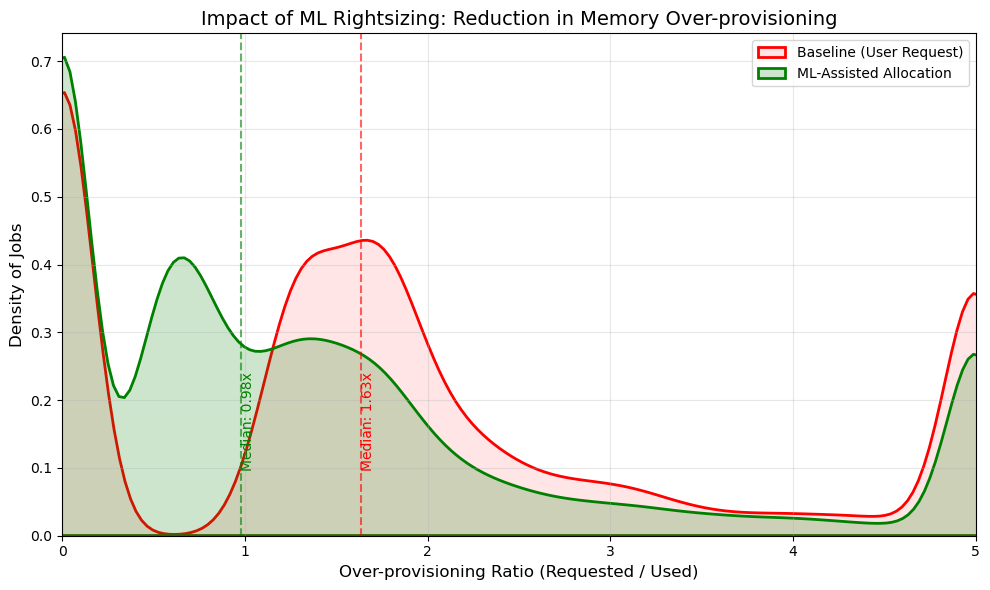

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration for the Plot ---
# We clip the data to reasonable limits (e.g., 0 to 5x) 
# because some jobs have infinite over-provisioning (near-zero usage), which ruins the graph.
PLOT_LIMIT = 5.0 

plt.figure(figsize=(10, 6))

# 1. Filter Data for Plotting (Remove extreme outliers for readability)
data_before = df_results['overprov_before']
data_after = df_results['overprov_after']

# Clip data to the range [0, PLOT_LIMIT]
data_before_clipped = data_before.clip(0, PLOT_LIMIT)
data_after_clipped = data_after.clip(0, PLOT_LIMIT)

# 2. Plot "Before" (Red Line - User Request)
sns.kdeplot(
    data_before_clipped, 
    color='red', 
    label='Baseline (User Request)', 
    fill=True, 
    alpha=0.1, 
    linewidth=2
)

# 3. Plot "After" (Green Line - ML Prediction)
sns.kdeplot(
    data_after_clipped, 
    color='green', 
    label='ML-Assisted Allocation', 
    fill=True, 
    alpha=0.2, 
    linewidth=2
)

# 4. Add Median Lines (The "40% Improvement" visual proof)
median_before = df_results['overprov_before'].median()
median_after = df_results['overprov_after'].median()

plt.axvline(median_before, color='red', linestyle='--', alpha=0.6)
plt.text(median_before, 0.1, f'Median: {median_before:.2f}x', color='red', rotation=90)

plt.axvline(median_after, color='green', linestyle='--', alpha=0.6)
plt.text(median_after, 0.1, f'Median: {median_after:.2f}x', color='green', rotation=90)

# 5. Formatting
plt.title('Impact of ML Rightsizing: Reduction in Memory Over-provisioning', fontsize=14)
plt.xlabel('Over-provisioning Ratio (Requested / Used)', fontsize=12)
plt.ylabel('Density of Jobs', fontsize=12)
plt.xlim(0, PLOT_LIMIT)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()